In [31]:
import numpy as np
import torch
import copy
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from DE import *

In [2]:
args = {"batch_size":64, "test_batch_size":1000, "epochs":5, 
            "lr":1.0, "gamma":0.7, "cuda":False, 
            "mps":True, "dry_run":False, 
            "seed":1, "log_interval":10, "save_model":False}

In [125]:
# Функція для навчання моделі для одного epoch
def train(args, model, device, train_loader, optimizer, epoch, print_stats = True):
    # Встановлюємо режим навчання у моделі
    model.train()
    # Список з точністю та значеннями функції втрат
    stats = []
    for batch_idx, (data, target) in enumerate(train_loader):
        # Переміщуємо дані на вказаний пристрій (CPU, CUDA або MPS)
        data, target = data.to(device), target.to(device)
        # Скидаємо градієнти з попередньої ітерації
        optimizer.zero_grad()
        # Обчислюємо передачення
        output = model(data)
        # Функція втрат (логарифмічний максимум правдоподібності)
        loss = F.nll_loss(output, target)
        # Обчислення градієнта втрат відносно параметрів моделі
        loss.backward()
        # Оновлюємо параметри оптимізатора так, щоб мінімізувати втрати
        optimizer.step()
        # Друкуємо статистику кожні log_interval кроків
        if batch_idx % args["log_interval"] == 0 and print_stats:
            accuracy = 100. * batch_idx / len(train_loader)
            print('Train Epoch: {} \t Accuracy: {:.2f}% \t Loss: {:.6f}'.format(epoch, accuracy, loss.item()))
            stats.append([accuracy, loss.item()])
            # Зупиняємо програму, якщо вибрано режим пробного запуску
            if args["dry_run"]:
                break
    return stats

In [126]:
# Функція для оцінки моделі на тестовому наборі даних
def test(model, device, test_loader, print_stats = True):
    # Встановити режим оцінки у моделі
    model.eval()
    test_loss = 0
    correct = 0
    # Вимикаємо обчислення градієнта для оцінки
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            # Обчислюємо суму втрат для пакету
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            # Отримуємо індекс передбачення з найбільшою ймовірністю
            pred = output.argmax(dim=1, keepdim=True)
            # Обчислюємо кількість правильних передбачень
            correct += pred.eq(target.view_as(pred)).sum().item()
    # Середні втрати на тестовий зразок
    test_loss /= len(test_loader.dataset)
    # Обчислюємо точність у відсотках
    accuracy = 100. * correct / len(test_loader.dataset)
    # Друкуємо точність та втрати
    if print_stats:
        print('\nTest set: Accuracy: {:.2f}%, Average loss: {:.4f}\n'.format(accuracy, test_loss))
    return [accuracy, test_loss]

In [127]:
# Функція для завантаження даних та запуску циклів навчання/тестування
def run(model, args, print_stats = True):
    # Встановлюємо початкове значення для генерації випадкових чисел на всіх пристроях
    torch.manual_seed(args["seed"])
    # Встановлюємо пристрій для використання (CUDA, MPS або CPU)
    if args["cuda"] and torch.cuda.is_available():
        device = torch.device("cuda")
    elif args["mps"] and torch.backends.mps.is_available():
        device = torch.device("mps")
    else:
        device = torch.device("cpu")
    # Встановлюємо розміри навчальних та тестових пакетів
    train_kwargs = {'batch_size': args["batch_size"]}
    test_kwargs = {'batch_size': args["test_batch_size"]}
    # Налаштування для CUDA, якщо використовується GPU
    if args["cuda"]:
        cuda_kwargs = {'num_workers': 1,
                        'pin_memory': True,
                        'shuffle': True}
        train_kwargs.update(cuda_kwargs)
        test_kwargs.update(cuda_kwargs)
    # Визначаємо перетворення даних: конвертувати в тензор та нормувати
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])
    # Завантажуємо набір даних MNIST
    dataset1 = datasets.MNIST('../data', train=True, download=True, transform=transform)
    dataset2 = datasets.MNIST('../data', train=False, transform=transform)
    train_loader = torch.utils.data.DataLoader(dataset1,**train_kwargs)
    test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)
    # Переміщуємо модель на вибраний пристрій
    model = model.to(device)
    # Ініціалізуємо оптимізатор
    optimizer = optim.Adadelta(model.parameters(), lr=args["lr"])
    # Зменшуємо швидкість навчання (learning rate) кожної групи параметрів на гамму кожні епохи step_size
    scheduler = StepLR(optimizer, step_size=1, gamma=args["gamma"])
    result_train = []
    result_test = []
    # Запускаємо цикл навчання/тестування для кожного epoch
    for epoch in range(1, args["epochs"] + 1):
        stats_train = train(args, model, device, train_loader, optimizer, epoch, print_stats)
        result_train.append(stats_train)
        stats_test = test(model, device, test_loader, print_stats)
        result_test.append(stats_test)
        # Оновлення швидкості навчання
        scheduler.step()
    # Зберігаємо навчену модель у файлі
    if args["save_model"]:
        torch.save(model.state_dict(), "mnist_cnn.pt")
    return result_train, result_test

In [139]:
class CNN_more_layers(nn.Module):
    def __init__(self):
        super(CNN_more_layers, self).__init__()
        self.fc1 = nn.Linear(128 * 11 * 11, 50)
        self.fc2 = nn.Linear(50, 50)
        self.fc3 = nn.Linear(50, 10)
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.conv3 = nn.Conv2d(64, 128, 3, 1)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        output = F.log_softmax(x, dim=1)
        return output

In [138]:
model = CNN_more_layers()

In [134]:
device = torch.device("cuda" if args["cuda"] and torch.cuda.is_available()
                      else "mps" if args["mps"] and torch.backends.mps.is_available()
                      else "cpu")
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
test_dataset = datasets.MNIST('../data', train=False, transform=transform, download = True)
test_loader = DataLoader(test_dataset, batch_size=args["test_batch_size"], shuffle=False)

In [137]:
def evaluate_model(individual, print_stats = True):
    lr, gamma, batch_size = individual
    batch_size = int(round(batch_size / 16.0) * 16)
    args = {
        "batch_size": batch_size,
        "test_batch_size": 1000,
        "epochs": 2,
        "lr": lr,
        "gamma": gamma,
        "cuda": False,
        "mps": True,
        "dry_run": False,
        "seed": 1,
        "log_interval": 100,
        "save_model": False
    }
    model = CNN_more_layers()
    _, test_stats = run(model, args, print_stats)
    accuracy, _ = test_stats[-1]
    return -accuracy

In [136]:
%%time
bounds = [
    (0.01, 1.0),     # Learning rate
    (0.1, 0.99),     # Gamma
    (32, 128)        # Batch size
]

de = DifferentialEvolution(func=evaluate_model, bounds=bounds, pop_size=5, max_generations=3)
best_solution, best_score = de.optimize()

lr_best, gamma_best, batch_best = best_solution
batch_best = int(round(batch_best / 16.0) * 16)

print("\nBest Hyperparameters:")
print(f"Learning Rate: {lr_best:.4f}")
print(f"Gamma: {gamma_best:.4f}")
print(f"Batch Size: {batch_best}")
print(f"Accuracy: {-best_score:.2f}%")

Train Epoch: 1 	 Accuracy: 0.00% 	 Loss: 2.300362
Train Epoch: 1 	 Accuracy: 10.66% 	 Loss: 0.166838
Train Epoch: 1 	 Accuracy: 21.32% 	 Loss: 0.110426
Train Epoch: 1 	 Accuracy: 31.98% 	 Loss: 0.107130
Train Epoch: 1 	 Accuracy: 42.64% 	 Loss: 0.061090
Train Epoch: 1 	 Accuracy: 53.30% 	 Loss: 0.091742
Train Epoch: 1 	 Accuracy: 63.97% 	 Loss: 0.081016
Train Epoch: 1 	 Accuracy: 74.63% 	 Loss: 0.073195
Train Epoch: 1 	 Accuracy: 85.29% 	 Loss: 0.046737
Train Epoch: 1 	 Accuracy: 95.95% 	 Loss: 0.087577

Test set: Accuracy: 98.51%, Average loss: 0.0474

Train Epoch: 2 	 Accuracy: 0.00% 	 Loss: 0.034119
Train Epoch: 2 	 Accuracy: 10.66% 	 Loss: 0.121357
Train Epoch: 2 	 Accuracy: 21.32% 	 Loss: 0.023576
Train Epoch: 2 	 Accuracy: 31.98% 	 Loss: 0.042555
Train Epoch: 2 	 Accuracy: 42.64% 	 Loss: 0.006777
Train Epoch: 2 	 Accuracy: 53.30% 	 Loss: 0.010127
Train Epoch: 2 	 Accuracy: 63.97% 	 Loss: 0.050055
Train Epoch: 2 	 Accuracy: 74.63% 	 Loss: 0.016378
Train Epoch: 2 	 Accuracy: 85.29%

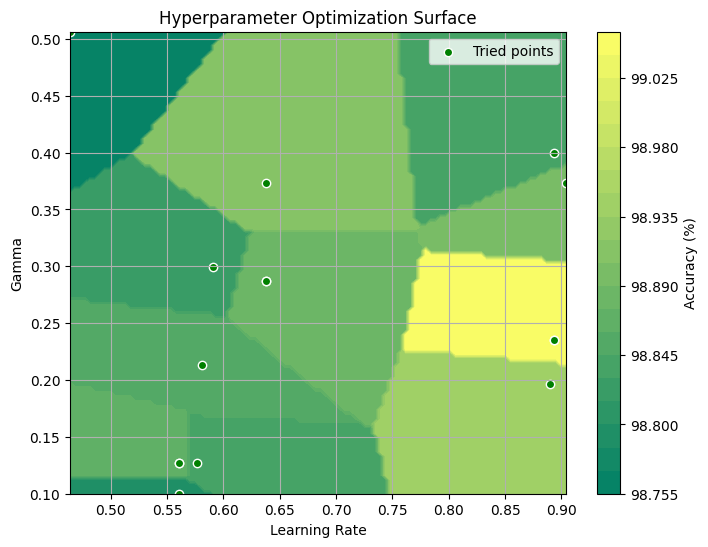

In [141]:
X = np.array([p[:2] for p in de.history_params])
Z = -np.array(de.history_scores)

x_min, x_max = X[:, 0].min(), X[:, 0].max()
y_min, y_max = X[:, 1].min(), X[:, 1].max()
xi = np.linspace(x_min, x_max, 100)
yi = np.linspace(y_min, y_max, 100)
xi, yi = np.meshgrid(xi, yi)


zi = griddata(X, Z, (xi, yi), method='nearest')
if np.any(np.isnan(zi)):
    zi = np.nan_to_num(zi, nan=Z.min())

plt.figure(figsize=(8, 6))
contour = plt.contourf(xi, yi, zi, levels=20, cmap='summer')
plt.colorbar(contour, label='Accuracy (%)')
plt.scatter(X[:, 0], X[:, 1], c='green', edgecolors='white', label='Tried points')
plt.xlabel('Learning Rate')
plt.ylabel('Gamma')
plt.title('Hyperparameter Optimization Surface')
plt.legend()
plt.grid()
plt.show()